In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta 
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, Date, cast

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [7]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
lastDateQ=session.query(Measurement).order_by(desc('date')).limit(1).all()[0]
lastDate = dt.datetime.strptime(lastDateQ.date, "%Y-%m-%d").date()
firstDate= lastDate - timedelta(days=365)
firstDateStr=firstDate.strftime('%Y-%m-%d') 
# Perform a query to retrieve the data and precipitation scores
selectDates = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > firstDateStr)

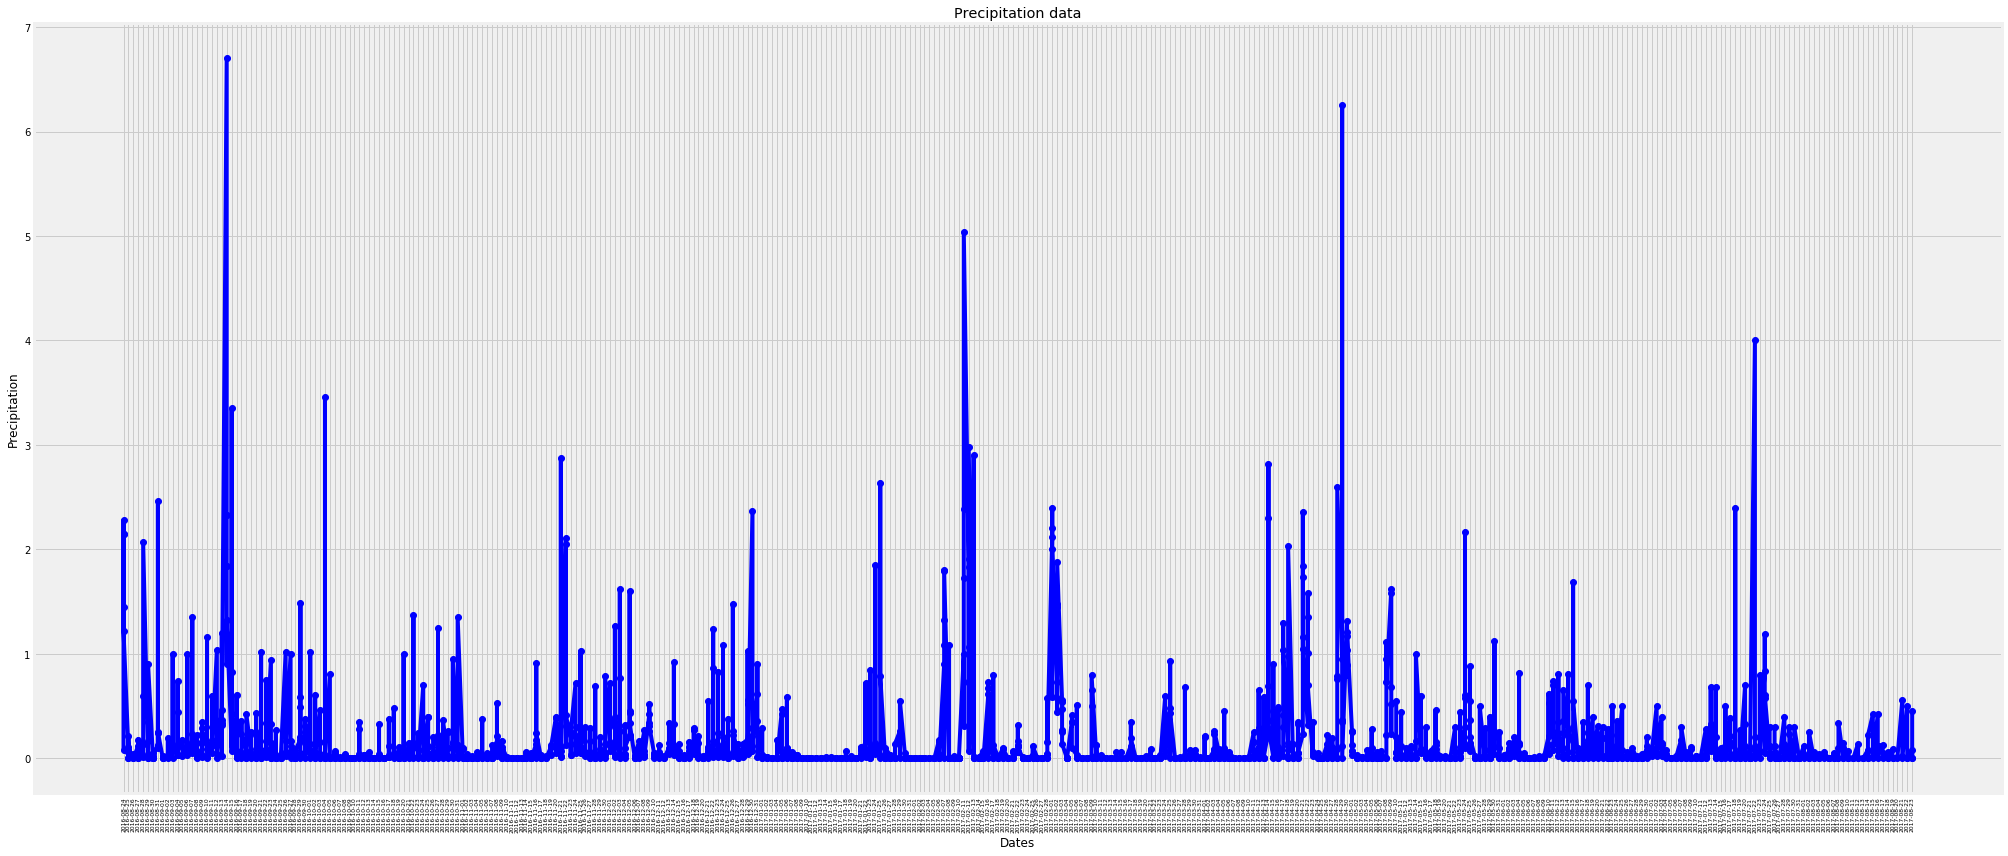

In [101]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(selectDates[:], columns=['date', 'precipitation'])

# (OTHER OPTION For direct query to DF )
''' 
query= " SELECT * FROM Measurement WHERE date > '+ firstDateStr +' "                                               
df= pd.read_sql(query, engine.connect())   
'''

sdf=df.sort_values(by=['date'])
sdf.dropna(inplace=True) 
allDates=pd.Series(sdf.date)    
allVals=pd.Series(sdf.precipitation)


fig, ax = plt.subplots(figsize=(28, 12))
ax.plot(allDates,allVals,'b-o')
ax.set_xlabel("Dates")
ax.set_ylabel("Precipitation")
plt.xticks(rotation=90,fontsize=6)
ax.set_title("Precipitation data")
fig.tight_layout()
plt.savefig("precipitation.png")
plt.show()


![precipitation](Images/precipitation.png)

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
indexed_df.describe()  # ( There's a difference in count beacuse of dropped NaNs )

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [67]:
# Design a query to show how many stations are available in this dataset?
stationsQ=session.query(Measurement).group_by(Measurement.station).count()
print(str(stationsQ)+' stations')

9 stations


In [86]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#from sqlalchemy import func
#session.query(Table.column, func.count(Table.column)).group_by(Table.column).all()

activeStationsQ=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()

for ast in activeStationsQ:
    print(ast)
    

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [ ]:
mostActive=activeStationsQ[0][0] 
stationxQ=session.query(func.max(Measurement.tobs).label("max_temp")).\
                       func.mean(Measurement.tobs).label("avg")).\
                        filter(Measurement.station==mostActive) 

In [103]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActive=activeStationsQ[0][0] 
stationxQ=session.query(func.max(Measurement.tobs).label("max_temp"),func.min(Measurement.tobs).label("min_temp"), func.sum(Measurement.tobs).label("sum"),func.count(Measurement.tobs).label("count")).filter(Measurement.station==mostActive) 
print(f'Max temp: {stationxQ[0].max_temp}, Min Temp:{stationxQ[0].min_temp}, Avergae Temp:{int(stationxQ[0].sum)/int(stationxQ[0].count)}' )

    

Max temp: 85.0, Min Temp:54.0, Avergae Temp:71.66378066378067


(array([ 6., 10., 15., 27., 41., 58., 72., 87., 31.,  9.]),
 array([59. , 61.4, 63.8, 66.2, 68.6, 71. , 73.4, 75.8, 78.2, 80.6, 83. ]),
 <a list of 10 Patch objects>)

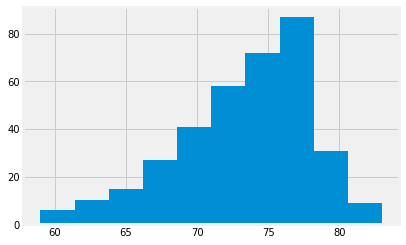

In [116]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# get the last date of data 
active12Q=session.query(Measurement.station, Measurement.date).filter(Measurement.station==mostActive).\
    order_by(desc(Measurement.station)).all() 
#calculate one year back
lastDate = dt.datetime.strptime(active12Q[len(active12Q)-1].date, "%Y-%m-%d").date()  #make as date
firstDate= lastDate - timedelta(days=365) # subtract 1 yr
firstDateStr=firstDate.strftime('%Y-%m-%d')  #make aks string
#query data for most active station in such date range
lastYearActiveStation=session.query(Measurement.tobs).filter(Measurement.station==mostActive).\
filter(Measurement.date >firstDateStr)

temps=[]
for l in lastYearActiveStation: 
    temps.append(l.tobs)

#plot histogram
#pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)[source]¶
plt.hist(temps)



![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
